# Noise Interferometry Test
This tests the functionality of the noise interferometry module of ooipy

## Sections
- Compute Cross Correlation for specified window

First, let's import all dependancies

In [1]:
import os
import sys
cwd = os.getcwd()
ooipy_dir = os.path.dirname(cwd) + '/ooipy'
sys.path.append(ooipy_dir)
from matplotlib import pyplot as plt
import datetime
import numpy as np
from obspy import read,Stream, Trace
from obspy.core import UTCDateTime
from ooipy.hydrophone import Noise_Interferometry as NI
import pickle
import scipy
from gwpy.timeseries import TimeSeries
import seaborn as sns
import gwpy
import progressbar

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Calculating NCF for 1 Average Period

In [2]:
# Create instance of NCF object
avg_time = 60 #minute
start_time = datetime.datetime(2017,3,10,0,0,0)
node1 = '/LJ01C'
node2 = '/PC01A'
filter_cutoffs = [20, 70]
W = 30

NCF0 = NI.NCF(avg_time, start_time, node1, node2, filter_cutoffs, W, verbose=True, whiten=True)
NCF0 = NI.calculate_NCF(NCF0)

plt.plot(NCF0.NCF)

   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 66.16511726379395 




# Loop Through 2 instances of NCF Calculation

In [6]:
NI.calculate_NCF_loop(2, node1, node2, 1, start_time, W,  filter_cutoffs, verbose=True, whiten=True)

Calculting NCF for Period 1:
   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 9.200584411621094 


Calculting NCF for Period 2:
   Getting Audio from Node 1...
   Getting Audio from Node 2...
   Filtering and Whitening Data for Node 1...
   Filtering and Whitening Data for Node 2...
   Correlating Data...
   Time to Calculate NCF for 1 Average Period: 9.003805160522461 




# NCF_analysis toolset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2017-03-10 23:00:00
[ 1 90]
low_frequency
200
Central_Caldera
Axial_Base
90
sabra
Number of Available hours: 170
115526825708.0


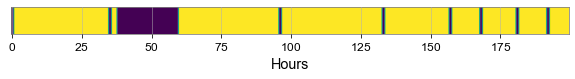

<Figure size 432x288 with 0 Axes>

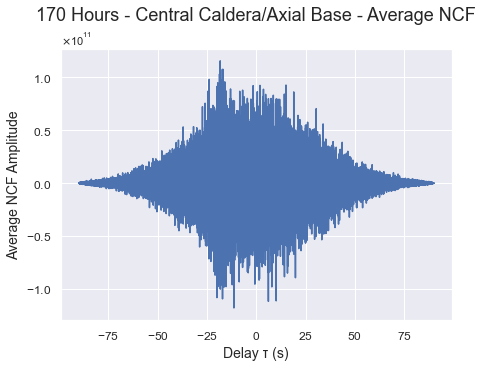

In [2]:
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import NCF_analysis as NCF

exp1 = NCF.NCF_analysis('ckpts_1')

exp1.read_header()
exp1.available_hours()

fig2 = plt.figure()
xcorr = exp1.average_NCF(500)

exp1.NCF_plot()

print(abs(max(xcorr)))

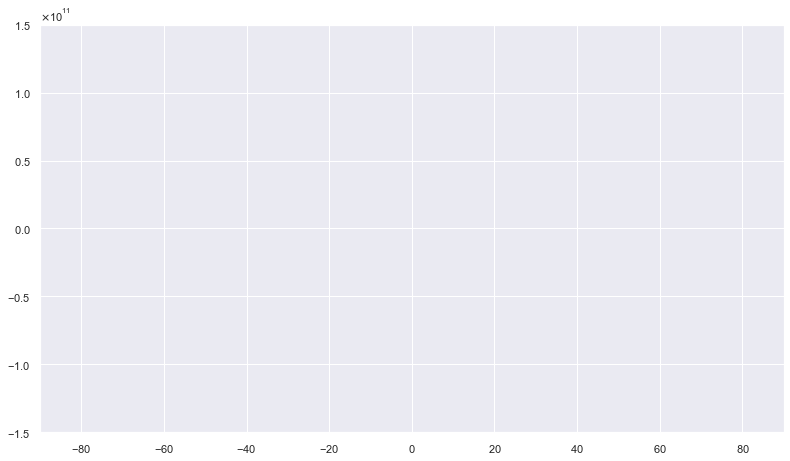

In [3]:
exp1.animate_NCF(400, 10, 'test', 1.5e+11)